<a href="https://colab.research.google.com/github/sankethgadadinni/LSTM-Time-Series/blob/main/goldpricepredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!nvidia-smi

Sat Jan  9 13:51:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [49]:
!pip install kaggle

In [50]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sankethgadadinni","key":"24af2328238021562621f8ae9f36d39f"}'}

In [51]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [52]:
!kaggle datasets download -d arashnic/learn-time-series-forecasting-from-gold-price

learn-time-series-forecasting-from-gold-price.zip: Skipping, found more recently modified local copy (use --force to force download)


In [53]:
!unzip -q 'learn-time-series-forecasting-from-gold-price.zip'

replace gold_price_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [113]:
import pandas as pd
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import mean_squared_error
from math import sqrt

In [59]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [115]:
data = pd.read_csv('/content/gold_price_data.csv', parse_dates = [0], index_col = 'Date')

In [116]:
data.head()

,Value
Date,
1970-01-01,35.2
1970-04-01,35.1
1970-07-01,35.4
1970-10-01,36.2
1971-01-01,37.4


In [117]:
data.isna().sum()

Value    0
dtype: int64

In [118]:
data.shape

(10787, 1)

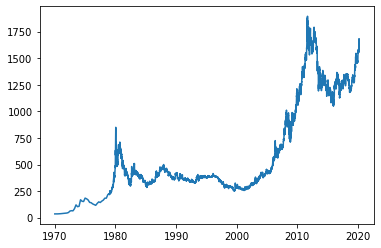

In [119]:
plt.plot(data)

In [120]:
scaler = MinMaxScaler(feature_range=(0,1))
data['Value'] = scaler.fit_transform(data['Value'].values.reshape(-1,1))

In [121]:
data.head()

,Value
Date,
1970-01-01,0.000054
1970-04-01,0.000000
1970-07-01,0.000161
1970-10-01,0.000591
1971-01-01,0.001237


In [122]:
def load_data(dataset, look_back):
    new_data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(dataset) - look_back): 
        new_data.append(dataset[index: index + look_back])
    
    new_data = np.array(new_data);
    test_set_size = int(np.round(0.2*new_data.shape[0]));
    train_set_size = new_data.shape[0] - (test_set_size);
    
    x_train = new_data[:train_set_size,:-1,:]
    y_train = new_data[:train_set_size,-1,:]
    
    x_test = new_data[train_set_size:,:-1]
    y_test = new_data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [123]:
look_back = 20
X_train, y_train, X_test, y_test = load_data(data, look_back)

In [124]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((8614, 19, 1), (2153, 19, 1), (8614, 1), (2153, 1))

In [125]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [126]:
X_train.shape

torch.Size([8614, 19, 1])

In [127]:
seq_len = look_back - 1
batch_size = 2153
epochs = 200

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [128]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [129]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim

        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
       
        return out

In [130]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

In [131]:
loss_fn = nn.MSELoss()

optimiser = optim.Adam(model.parameters(), lr=0.01)

In [132]:

hist = []
num_epochs = 200

for epoch in range(1,num_epochs+1):
s
    y_train_pred = model(X_train)

    loss = loss_fn(y_train_pred, y_train)
    
    hist.append(loss.item())

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

    if epoch % 10 == 0 :
        print('epoch : {}/{} ,MSE : {:.6f}'.format(epoch, num_epochs, loss.item()))

epoch : 10/200 ,MSE : 0.003678
epoch : 20/200 ,MSE : 0.005669
epoch : 30/200 ,MSE : 0.001872
epoch : 40/200 ,MSE : 0.001033
epoch : 50/200 ,MSE : 0.000468
epoch : 60/200 ,MSE : 0.000333
epoch : 70/200 ,MSE : 0.000184
epoch : 80/200 ,MSE : 0.000129
epoch : 90/200 ,MSE : 0.000100
epoch : 100/200 ,MSE : 0.000085
epoch : 110/200 ,MSE : 0.000075
epoch : 120/200 ,MSE : 0.000069
epoch : 130/200 ,MSE : 0.000065
epoch : 140/200 ,MSE : 0.000062
epoch : 150/200 ,MSE : 0.000060
epoch : 160/200 ,MSE : 0.000059
epoch : 170/200 ,MSE : 0.000058
epoch : 180/200 ,MSE : 0.000058
epoch : 190/200 ,MSE : 0.000057
epoch : 200/200 ,MSE : 0.000057


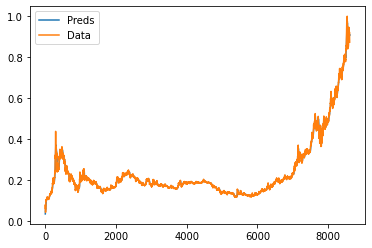

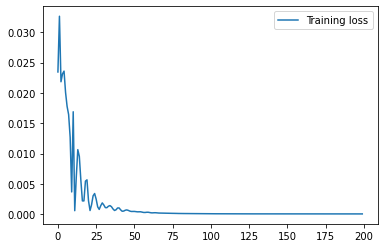

In [133]:
plt.plot(y_train_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [134]:
np.shape(y_train_pred)

torch.Size([8614, 1])

In [135]:
y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

In [136]:
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 14.00 RMSE
Test Score: 23.91 RMSE


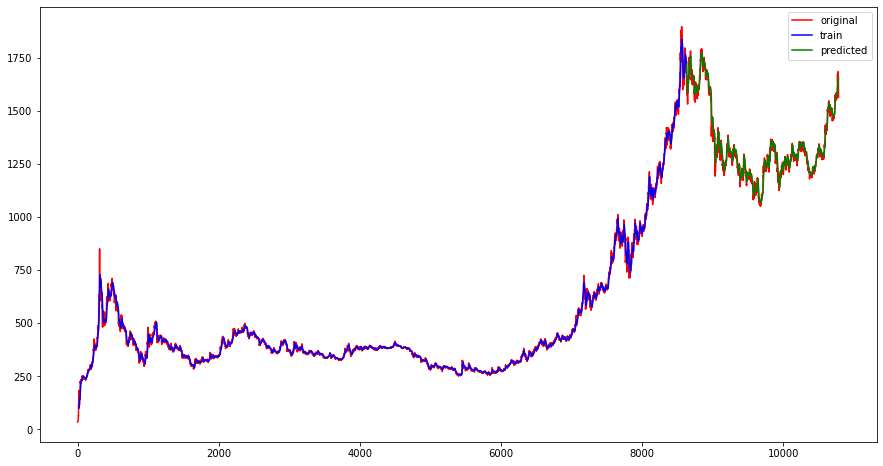

In [146]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred)+look_back, :] = y_train_pred


testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+look_back-1:len(data)-1, :] = y_test_pred


plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(data), color = 'red', label = 'original')
plt.plot(trainPredictPlot, color = 'blue', label = 'train')
plt.plot(testPredictPlot, color = 'green', label = 'predicted')
plt.legend()
plt.show()